In [15]:
import pandas as pd
import os
import pickle
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
#import statsmodels.api as sm 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [16]:
# Read csv-files
df = pd.read_csv("../data/clean_data.csv")
df_full = pd.read_csv("../data/clean_data_full.csv")

In [17]:
list(df_full.columns)

['realSum',
 'room_type',
 'person_capacity',
 'biz',
 'multi',
 'bedrooms',
 'dist',
 'metro_dist',
 'city',
 'period',
 'attr_index_norm',
 'rest_index_norm',
 'single']

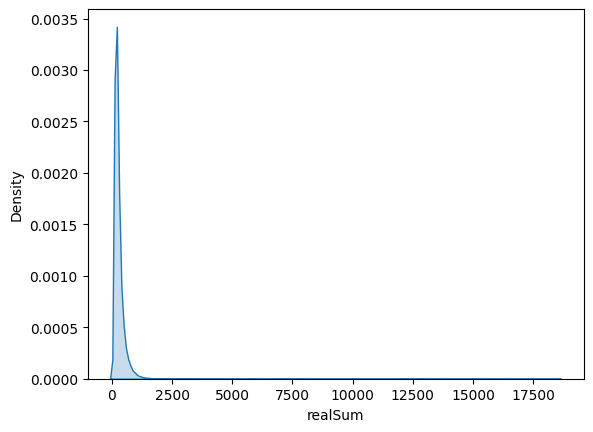

<Figure size 640x480 with 0 Axes>

In [18]:
figure=sns.kdeplot(df_full, x="realSum", fill=True)
fig = figure.get_figure()
fig.savefig('../plots/explore/realsum_density', dpi=200, bbox_inches='tight')
plt.show()
plt.clf()

<Axes: xlabel='realSum', ylabel='Density'>

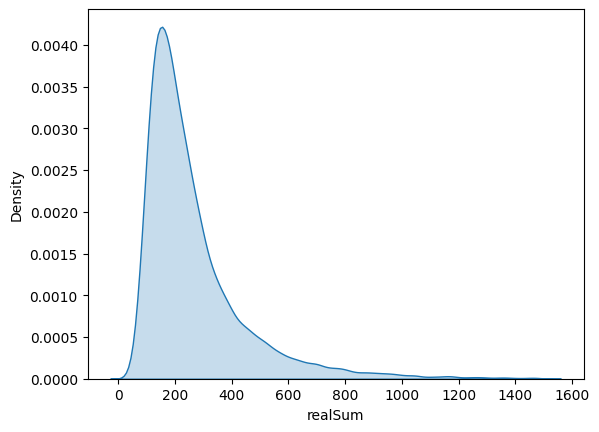

In [19]:
sns.kdeplot(df, x="realSum", fill=True)

In [20]:
hot_cols = ['room_type', 'city', 'period'] # Columns to one-hot encode

def one_hot_encode(df, categorical_cols):
    return pd.get_dummies(df, columns=categorical_cols, dtype=int)

df_full_hot = one_hot_encode(df = df_full, categorical_cols = hot_cols)
df_full_hot = df_full_hot.drop(columns='period_Weekends')

In [21]:
# filter out price over 1500
df_hot = df_full_hot[df_full_hot['realSum'] < 1500]

# print message
removed = df_full_hot.shape[0]-df_hot.shape[0]
percent = removed/df_full_hot.shape[0]
print(f'{removed} rows and {round(percent,4)}% of the data removed')

258 rows and 0.005% of the data removed


In [22]:
df_hot.head()

,realSum,person_capacity,biz,multi,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,single,...,city_Athens,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna,period_Weekdays
0,474.317499,4.0,1,0,1,1.111996,0.630491,17.942927,20.154890,0,...,0,1,0,0,0,0,0,0,0,1
1,169.897829,2.0,0,1,1,1.751839,0.124017,10.910462,17.484489,0,...,0,1,0,0,0,0,0,0,0,1
2,161.984779,4.0,1,0,1,1.670493,0.080322,11.726595,18.505814,0,...,0,1,0,0,0,0,0,0,0,1
3,367.956804,3.0,1,0,1,1.475847,0.093107,13.634603,20.837357,0,...,0,1,0,0,0,0,0,0,0,1
4,196.895292,3.0,0,1,1,1.855452,0.272486,11.793678,17.440874,0,...,0,1,0,0,0,0,0,0,0,1


In [23]:
df_hot.info()
# Why not a whole number?

<class 'pandas.core.frame.DataFrame'>
Index: 51449 entries, 0 to 51706
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   realSum                    51449 non-null  float64
 1   person_capacity            51449 non-null  float64
 2   biz                        51449 non-null  int64  
 3   multi                      51449 non-null  int64  
 4   bedrooms                   51449 non-null  int64  
 5   dist                       51449 non-null  float64
 6   metro_dist                 51449 non-null  float64
 7   attr_index_norm            51449 non-null  float64
 8   rest_index_norm            51449 non-null  float64
 9   single                     51449 non-null  int64  
 10  room_type_Entire home/apt  51449 non-null  int64  
 11  room_type_Private room     51449 non-null  int64  
 12  room_type_Shared room      51449 non-null  int64  
 13  city_Amsterdam             51449 non-null  int64  


In [24]:
df_hot.describe()

,realSum,person_capacity,biz,multi,bedrooms,dist,metro_dist,attr_index_norm,rest_index_norm,single,...,city_Athens,city_Barcelona,city_Berlin,city_Budapest,city_Lisbon,city_London,city_Paris,city_Rome,city_Vienna,period_Weekdays
count,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,...,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000,51449.000000
mean,266.487281,3.155086,0.350444,0.291512,1.153550,3.192631,0.682518,13.356674,22.755848,0.358044,...,0.102606,0.054792,0.048086,0.078058,0.111994,0.192054,0.128982,0.175319,0.068689,0.493226
std,185.161271,1.294595,0.477114,0.454463,0.620444,2.395683,0.859630,9.698984,17.791286,0.479430,...,0.303447,0.227576,0.213951,0.268265,0.315363,0.393919,0.335183,0.380244,0.252928,0.499959
min,34.779339,2.000000,0.000000,0.000000,0.000000,0.015045,0.002301,0.926301,0.592757,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,148.639432,2.000000,0.000000,0.000000,1.000000,1.453456,0.248654,6.362049,8.729172,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,210.365854,3.000000,0.000000,0.000000,1.000000,2.614077,0.413574,11.433836,17.512787,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,317.062311,4.000000,1.000000,1.000000,1.000000,4.263675,0.739171,17.355586,32.940894,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1497.683389,6.000000,1.000000,1.000000,10.000000,25.284557,14.273577,100.000000,100.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/tmp/ipykernel_7347/1620204390.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  corr_var_filtered = corr_var.applymap(replace_with_zero)


<Axes: >

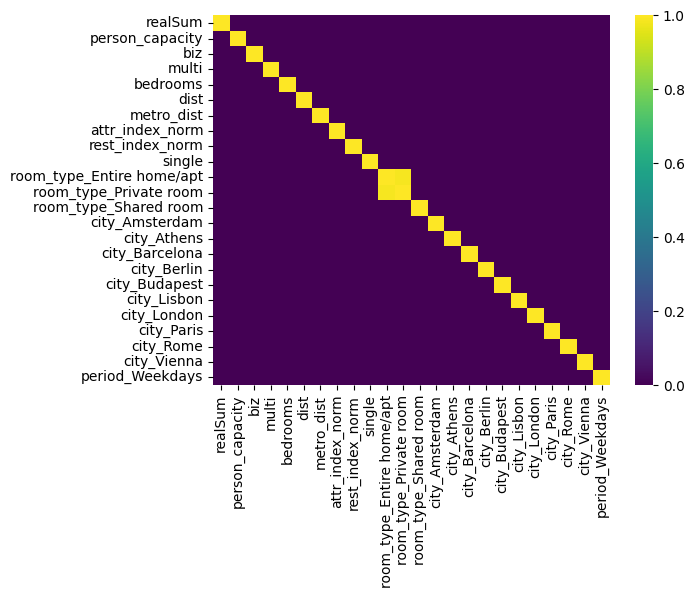

In [33]:
# Checking correlation / collinearity between predictors
corr_var = df_hot.corr()
corr_var_abs = corr_var.abs()
#corr_var.to_csv('../data/correlations.csv', index=False)

# Function to replace values between -0.5 and 0.5 with 0
def replace_with_zero(x):
    return 0 if -0.7 < x < 0.7 else x

# Apply the function to the entire DataFrame
corr_var_filtered = corr_var.applymap(replace_with_zero)
corr_var_filtered_abs = corr_var_filtered.abs()

#sns.heatmap(corr_var_abs)
sns.heatmap(corr_var_filtered_abs, cmap='viridis')

In [26]:
# drop columns
df_hot2 = df_hot.drop(columns=['room_type_Shared room', 'room_type_Private room'])

/tmp/ipykernel_7347/1874247841.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hot2_corr_filtered = df_hot2_corr.applymap(replace_with_zero)


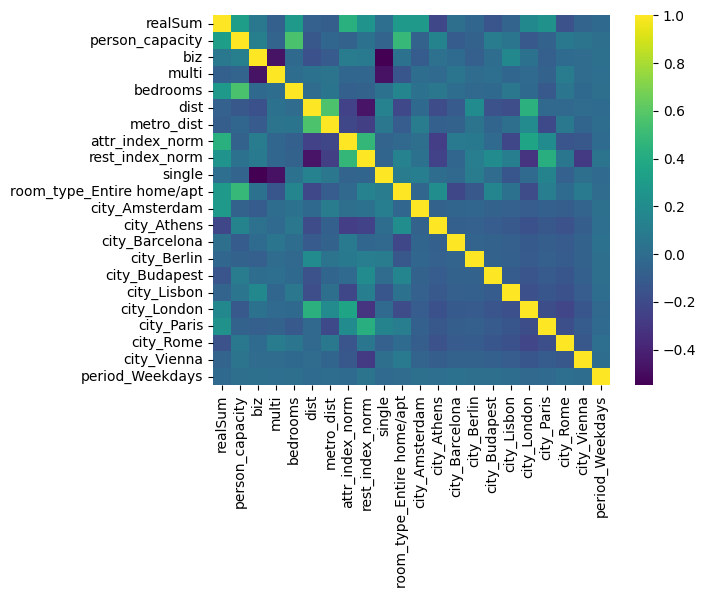

In [32]:
df_hot2_corr = df_hot2.corr()
sns.heatmap(df_hot2_corr, cmap='viridis')

# Function to replace values between -0.5 and 0.5 with 0
def replace_with_zero(x):
    return 0 if -0.5 < x < 0.5 else x

df_hot2_corr_filtered = df_hot2_corr.applymap(replace_with_zero)
#sns.heatmap(df_hot2_corr_filtered, cmap='viridis')

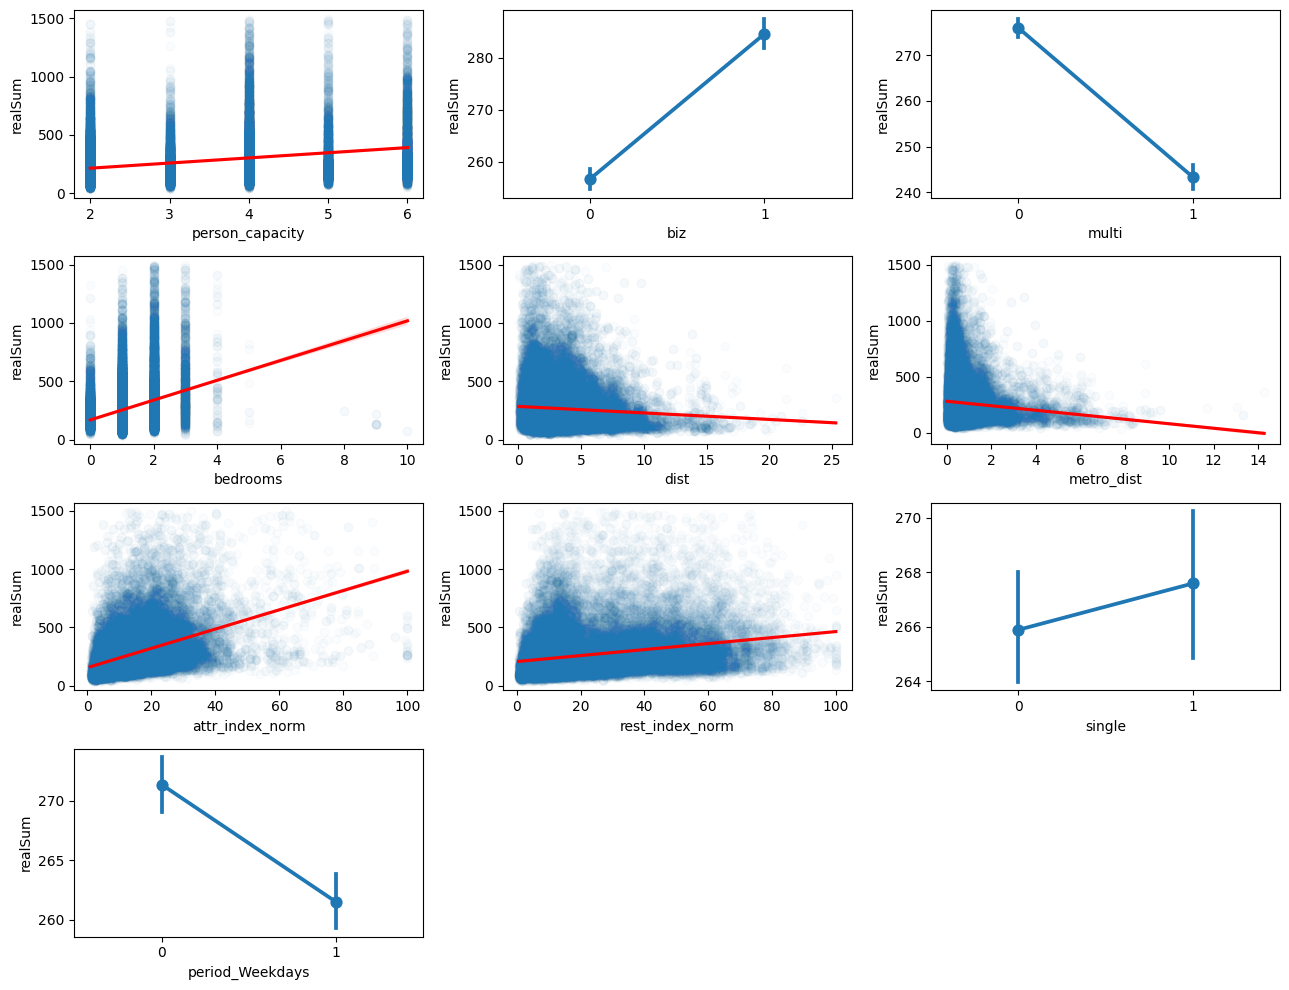

In [28]:
dummy_cols = ['biz', 'multi','single','room_type_Entire home/apt', 'city_Amsterdam', 'city_Athens', 'city_Barcelona','city_Berlin', 'city_Budapest','city_Lisbon','city_London', 'city_Paris', 'city_Rome', 'city_Vienna', 'period_Weekdays' ]

df_hot2_plot1 = df_hot2[['realSum', 'person_capacity', 'biz', 'multi', 'bedrooms', 'dist', 'metro_dist', 'attr_index_norm', 'rest_index_norm','single', 'period_Weekdays']]
df_hot2_plot2 = df_hot2[['realSum', 'city_Amsterdam', 'city_Athens', 'city_Barcelona', 'city_Berlin', 'city_Budapest', 'city_Lisbon', 'city_London','city_Paris', 'city_Rome','city_Vienna']]

# Assuming df_hot2_plot1 and dummy_cols are already defined
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(13,10))
plot_idx = list(itertools.product(range(4), range(3)))

# Filter columns to plot
columns_to_plot = [c for c in df_hot2_plot1.columns if c != 'realSum']
num_plots = len(columns_to_plot)

for i, c in enumerate(columns_to_plot):
    if c in dummy_cols:
        sns.pointplot(data=df_hot2_plot1, x=c, y='realSum', ax=ax[plot_idx[i]])
    else:
        #.scatterplot(data=df_hot2_plot1, x=c, y='realSum', ax=ax[plot_idx[i]], alpha=0.02)
        sns.regplot(data=df_hot2_plot1, x=c, y='realSum', ax=ax[plot_idx[i]], scatter_kws={'alpha':0.02}, line_kws={'color': 'red'}, ci = 95)

# Hide unused subplots if any
for j in range(num_plots, len(plot_idx)):
    ax[plot_idx[j]].set_visible(False)

plt.tight_layout()
plt.show()

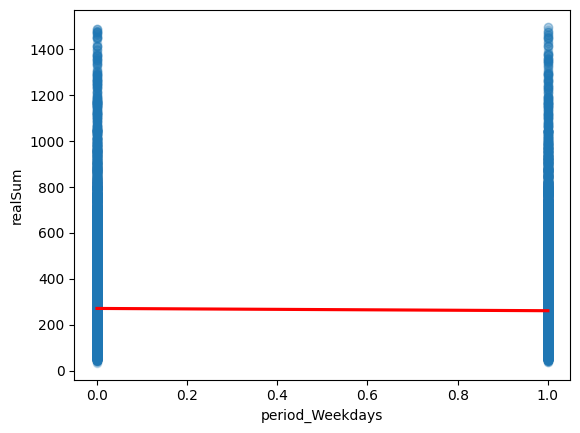

In [29]:
# Simplified test
sns.regplot(data=df_hot2_plot1, x='period_Weekdays', y='realSum', scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'}, ci=95)
plt.show()

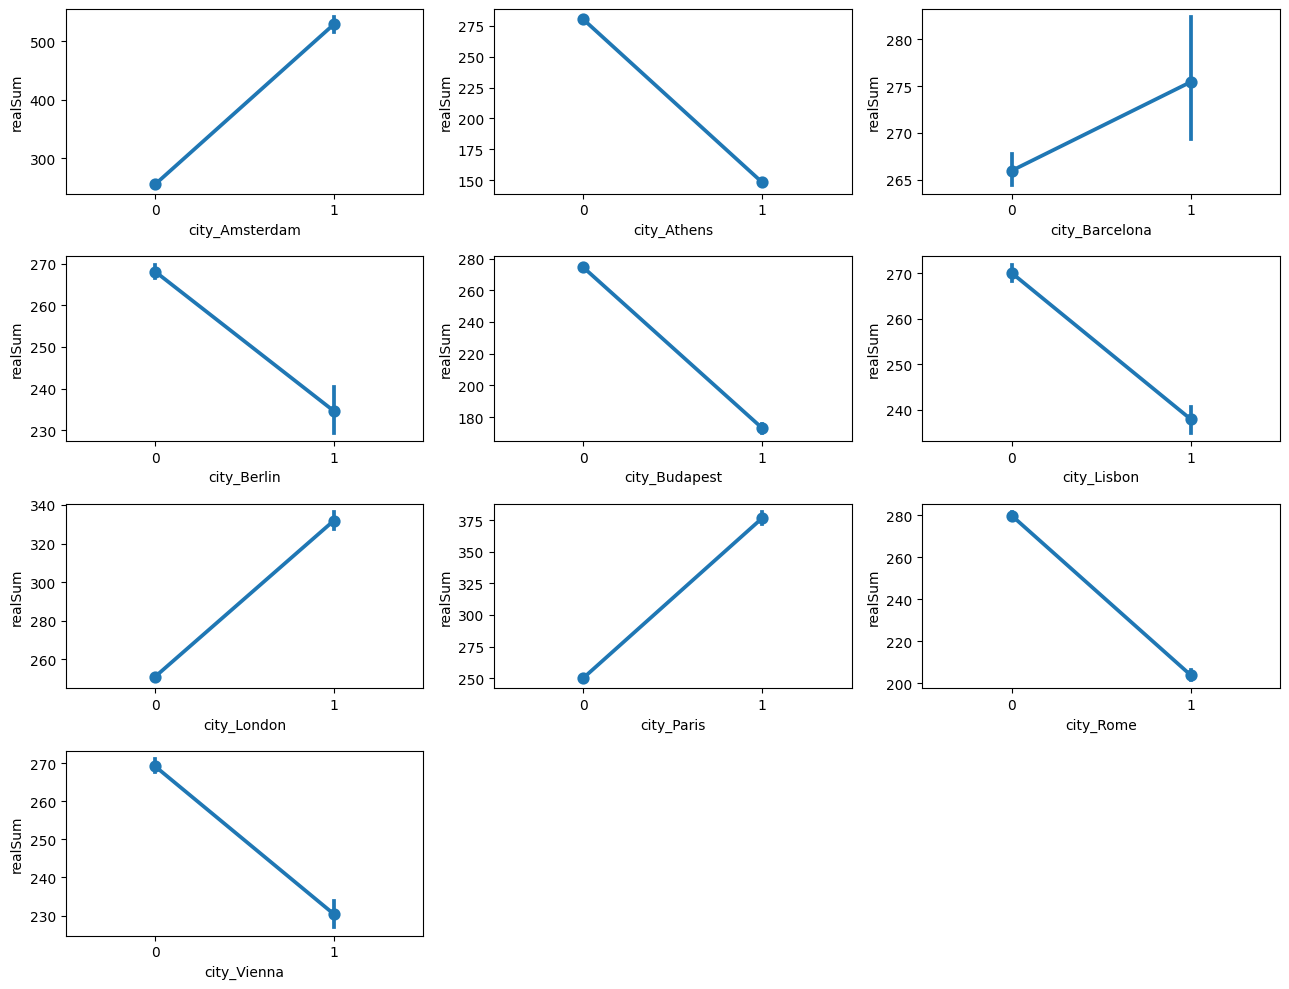

In [30]:

# Assuming df_hot2_plot2 and dummy_cols are already defined
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(13,10))
plot_idx = list(itertools.product(range(4), range(3)))

# Filter columns to plot
columns_to_plot = [c for c in df_hot2_plot2.columns if c != 'realSum']
num_plots = len(columns_to_plot)

for i, c in enumerate(columns_to_plot):
    if c in dummy_cols:
        sns.pointplot(data=df_hot2_plot2, x=c, y='realSum', ax=ax[plot_idx[i]])
    else:
        sns.scatterplot(data=df_hot2_plot2, x=c, y='realSum', ax=ax[plot_idx[i]], alpha=0.02)

# Hide unused subplots if any
for j in range(num_plots, len(plot_idx)):
    ax[plot_idx[j]].set_visible(False)

plt.tight_layout()
plt.show()